# Objective

The goal of this project is to generate a segmentation mask for neurons that differentiates the soma and neurites from the background.
This primarily useful for automation features, such as morphological measurements, cell counting, etc.
We'll be doing this using a variant of U-net, which is a common choice for segmentation tasks in cellular biology. With the model defined,
we then train it on the synthetically generated data.

*Note: You can use the outline of this notebook to navigate the sections.*

# Setup

The following sections are for setting up the environment to load the ata and run the model.

## Import Dependencies

In [1]:
# Standard Library Imports
import logging
import time
import os
from pathlib import Path
from dataclasses import dataclass
from random import Random
from uuid import uuid4

# Third-Party Libraries
import numpy as np
import matplotlib. pyplot as plt 
import torch
from torch import nn, Tensor
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2.functional as FT
from torchvision.utils import make_grid
from torchvision.io import read_image
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

# MLflow for Experiment Tracking and Model Management
import mlflow

# Local module for configuration data.
import userconfig

2025-06-09 17:24:02.604434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749489842.634645    7583 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749489842.647492    7583 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 17:24:02.703939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configure Logging

In [2]:
# Configure the logging module with desired format and level
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger for this notebook
logger = logging.getLogger('segmentation-notebook')
logger.info("Logging configured successfully")

2025-06-09 17:24:07 | segmentation-notebook | INFO | Logging configured successfully


# Model Architecture and Implementation

The U-net model, in general, works by successively encoding features until the spatial resolution has been downsized by factor of 4 or 8.
After that, the model progressively up samples and concatenates features from prior encoding states. It can be thought of as an auto encoder
with skip connections. There are several variations, such as the addition of residual blocks or residual connections, but we will be using
the foundational version. The nice thing about U-net is that it is fully convolutional, so even if we train with a small spatial resolution,
we can use larger spatial resolutions during deployment.

Here is a diagram that illustrates what is happening visually.

<p align="center">
    <img src="../docs/unet.png" />
</p>

Many variants of U-net will go deeper, and many will also have batch normalization and activation functions along side the convolutions.
This diagram is a slight simplification in that it only includes the convolution, interpolation, and concatenation functions of the network.

## Encoder

In [3]:
class _Encoder(nn.Module):
    """
    Used for down sizing the input and encoding new features.
    This modules all have a stride of 2, a kernel size of 3, and a padding of 1.
    So any input signal that is passed to it will have an output whose spatial
    resolution is half of that of the input.
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the encoder.

        :param in_channels: The number of input channels to the module.
        :param out_channels: The number of output channels to return by the module.
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Runs the forward pass of the module.

        :param x: The input signal to the module.

        :returns: The down sampled output of the module, pairsed with the original input signal.
                  The original input signal may be used later for skip connections to the decoders.
        """
        skip = x
        x = self.conv(x)
        x = self.norm(x)
        x = F.leaky_relu(x)
        return x, skip

def test_encoder():
    enc = _Encoder(16, 32)
    x = torch.randn((4, 16, 128, 128))
    y, skip = enc(x)
    assert(y.shape[0] == 4)
    assert(y.shape[1] == 32)
    assert(y.shape[2] == 64)
    assert(y.shape[3] == 64)
    assert(skip.shape == x.shape)
    logger.info('Encoder works.')

test_encoder()

2025-06-09 17:24:07 | segmentation-notebook | INFO | Encoder works.


## Decoder

In [4]:
class _Decoder(nn.Module):
    """
    This module is used for up sampling the decoded feature maps by
    a factor of two and reconstructing detail. It also handles the
    concatenation of previous feature maps (in other words, handles
    the skip connections).
    """
    def __init__(self, in_channels: int, out_channels: int):
        """
        Initializes the decoder module.

        :param in_channels: The number of input channels for this module.
                            Note that this should include the number of channels
                            of the signal being concatenated.
        :param output_channels: The number of output channels to return from this module.
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor, skip: Tensor) -> Tensor:
        """
        Runs the forward pass of this module.

        :param x: The input signal to upsample.
        :param skip: The skip connection to concatenate to the input signal.

        :returns: The output of the module.
        """
        shape = (skip.shape[2], skip.shape[3])
        x = F.interpolate(x, size=shape, mode='bilinear')
        x = torch.concat((x, skip), dim=1)
        x = self.conv(x)
        x = self.norm(x)
        x = F.leaky_relu(x)
        return x

def test_decoder():
    x = torch.randn((4, 16, 32, 32))
    skip = torch.randn((4, 8, 64, 64))
    dec = _Decoder(24, 4)
    y = dec(x, skip)
    assert(y.shape[0] == 4)
    assert(y.shape[1] == 4)
    assert(y.shape[2] == 64)
    assert(y.shape[3] == 64)
    logger.info('Decoder works.')
test_decoder()

2025-06-09 17:24:07 | segmentation-notebook | INFO | Decoder works.


## U-Net

In [5]:
class UNet(nn.Module):
    """
    A class for building the architecture of the U-net model.
    """
    def __init__(self, input_features: int = 1):
        """
        Initializes the network.

        :param input_features: The number of channels used by the input image. For microscopy, this is generally single
                               channel, but it is sometimes 3 channels for widefield microscopy. For confocal microscopy,
                               this may be many channels, where each represents a thin slice of the specimen along the Z axis.
        """
        try:
            super().__init__()
            self.input_features = input_features
            self.enc1 = _Encoder(input_features, 16)
            self.enc2 = _Encoder(16, 64)
            self.enc3 = _Encoder(64, 128)
            self.enc4 = _Encoder(128, 256)
            self.dec4 = _Decoder(256 + 128, 128)
            self.dec3 = _Decoder(128 + 64, 64)
            self.dec2 = _Decoder(64 + 16, 32)
            self.dec1 = _Decoder(32 + 1, 32)
            self.last = nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False)
            )
            logger.info("U-net initialization done successfully")
        except Exception as e:
            logger.error(f"Error initializing U-net: {e}")
            raise    

    def forward(self, x: Tensor) -> Tensor:
        """ 
        Implementation of the U-net logic, in which, the input passes through every step of the architecture.

        :param x: Input image from microscope.

        :returns: The segmentation mask of the input image, at the same spatial resolution.
        """
        try:
            x, skip0 = self.enc1(x)
            x, skip1 = self.enc2(x)
            x, skip2 = self.enc3(x)
            x, skip3 = self.enc4(x)
            x = self.dec4(x, skip3)
            x = self.dec3(x, skip2)
            x = self.dec2(x, skip1)
            x = self.dec1(x, skip0)
            x = self.last(x)
            return x
        except Exception as e:
            logger.error(f"Error implementing U-net logic: {e}")
            raise 

    def smoke_test(self, res: tuple[int, int] = (512, 512), batch_size: int = 4):
        """
        This module is for verifying that the network correctly handles the input tensor.
        It primarily catches shape errors and input data type errors.

        :param res: The spatial resolution to test with.
        :param batch_size: The batch size to test with.
        """
        x = torch.randn((batch_size, self.input_features, res[0], res[1]))
        self.eval()
        try:
            y: Tensor = self.forward(x)
            assert(y.shape[0] == batch_size)
            assert(y.shape[1] == 3)
            assert(y.shape[2] == res[0])
            assert(y.shape[3] == res[1])
            logger.info('U-net works.')
        except Exception as e:
            logger.error(f'Failed to run basic network test: {e}')
            raise

def check_unet():
    model = UNet()
    model.smoke_test()
check_unet()

2025-06-09 17:24:07 | segmentation-notebook | INFO | U-net initialization done successfully
2025-06-09 17:24:10 | segmentation-notebook | INFO | U-net works.


# Data

This section goes into loading the data and performing data augmentations to help model generalization.

## Dataset

In [6]:
@dataclass
class _Sample:
    """
    This class stores one training sample of the dataset.
    It consists of an input image and the target segmentation mask.
    The class will either store the path or the tensor. Initially,
    the path is only stored. Once the sample is used, the image is
    opened and the path is replaced with the image tensor. This is
    essentially lazy loading and speeds up training after the first
    epoch without having to wait for the whole dataset to be loaded
    before starting the training loop.
    """
    image: Path | Tensor
    target: Path | Tensor

class _IdentityTransform(nn.Module):
    """
    This is a null-object that is used in place of an actual transform in the dataset.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor, target: Tensor) -> tuple[Tensor, Tensor]:
        return x, target

class SegmentationDataset(Dataset):
    """
    This is a dataset for training the segmentation network.
    It reads a directory containing input images and segmentation
    mask images. The input images should be PNG files with 5 digits
    to indicate the index of the image (with zero padding). For
    example: "00000.png". Each one of this images should have a
    corresponding "{index:05}_mask.png", which is the target segmentation
    mask that the network should learn to reproduce. For example,
    the input image "00123.png" should have a corresponding "00123_mask.png".
    The segmentation mask should consist of three channels: red, green and blue.
    Red represents the soma, green represents a neurite, and blue represents
    the background.
    """
    def __init__(self, img_dir: Path, cache: bool, transform):
        """
        Initialize the segmentation dataset.

        :param img_dir: Image directory containing input images and target segmentation masks.
        :param cache: Whether or not to cache the images in memory.
        :param transform: An optional data transformation function. Must be callable.
        """
        try:
            super().__init__()
            self.cache = cache
            self.samples: list[_Sample] = []
            self.transform = transform if transform is not None else _IdentityTransform()
            for entry in img_dir.glob('*'):
                if 'mask' in entry.stem:
                    continue
                index = int(str(entry.stem))
                mask_entry = img_dir / f'{index:05}_mask.png'
                self.samples.append(_Sample(image=entry, target=mask_entry))

            logger.info(f"Segmentation dataset initialization done successfully (num_samples={len(self.samples)})")

        except Exception as e:
            logger.error(f"Error initializing segmentation dataset: {e}")
            raise

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        """
        Gets an input image and the target segmentation mask.

        :index: The index of the sample in the dataset.

        :returns: An input image and a target segmentation mask.
        """
        try:
            sample = self.samples[index]
            if self.cache:
                if isinstance(sample.image, Path):
                    sample.image = read_image(str(sample.image)).float() * (1.0 / 255.0)
                if isinstance(sample.target, Path):
                    sample.target = read_image(str(sample.target)).float() * (1.0 / 255.0)
                image = sample.image
                target = sample.target
                return self.transform(image, target)
            else:
                image = read_image(str(sample.image)) * (1.0 / 255.0)
                target = read_image(str(sample.target)) * (1.0 / 255.0)
                return self.transform(image, target)
        except Exception as e:
            logger.error(f"Error getting sample: {e}")
            raise

    def __len__(self):
        """
        Get the number of input and output pairs.

        :returns: The number of input and output pairs.
        """
        return len(self.samples)


## Data Augmentation

In [7]:
class AugmentationTransform:
    def __init__(self, seed: int):
        self.rng = Random(seed)

    def __call__(self, x: Tensor, target: Tensor) -> tuple[Tensor, Tensor]:
        if self.rng.randint(0, 1) == 1:
            x = FT.horizontal_flip(x)
            target = FT.horizontal_flip(target)
        if self.rng.randint(0, 1) == 1:
            x = FT.vertical_flip(x)
            target = FT.vertical_flip(target)
        if self.rng.randint(0, 1) == 1:
            ks = 3 + self.rng.randint(1, 3) * 2
            x = FT.gaussian_blur(x, kernel_size=[ks, ks], sigma=[self.rng.uniform(1.0, 9.0)])
        if self.rng.randint(0, 1) == 1:
            n = torch.randn_like(x)
            x = x + (n - x) * self.rng.uniform(0.01, 0.1)
        return x, target

## Test Augmentation

To make sure the data that is getting passed to the network is not completely messed up,
we verify by inspection that it is okay.

2025-06-09 17:24:10 | segmentation-notebook | INFO | Segmentation dataset initialization done successfully (num_samples=600)


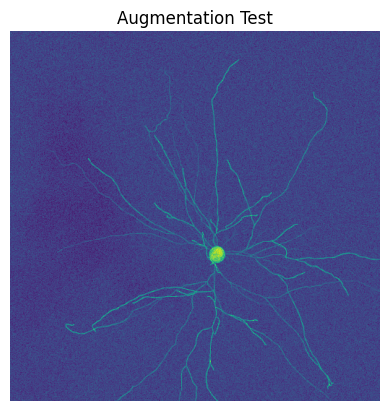

In [8]:
def test_augmentation():
    with torch.no_grad():
        seed = int(time.time())
        data = SegmentationDataset(Path('../data/imagery/val'), cache=False, transform=AugmentationTransform(seed=seed))
        index = Random(seed).randint(0, len(data) - 1)
        x, target = data[index]
    plt.imshow(x[0])
    plt.title('Augmentation Test')
    plt.axis('off')
    plt.show()
test_augmentation()

# Training and Validation

In [9]:
import torch.utils.tensorboard


class TrainingLoop(object):
    def __init__(self,
                 config: userconfig.UserConfig,
                 model: nn.Module,
                 optimizer: optim.Optimizer,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 device):
        """
        Initialize the model training object.

        :model: U-net model.
        :criterion: Measures the error between the output and the real value.
        :optimizer : Adjusts model weights for loss minimization.
        :train_loader: Training batches.
        :val_loader: Validation batches.
        :device: Where the model and data will be processed.
        """
        try:
            self.model = model
            self.optimizer = optimizer
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.device = device
            self.tb_writer = torch.utils.tensorboard.SummaryWriter(str(Path(config.tensorboard_dir) / str(uuid4())))
            self.best_metric = float('inf')
            self.best_epoch = -1
            self.user_config = config

            logger.info('Training object initialization done successfully')
            
        except Exception as e:
            logger.error(f'Error initializing training object: {e}')

    def train(self, num_epochs: int = 100):
        """
        Train the U-net model

        :param num_epochs: The number of epochs to train the model for.
        """
        try:
            self.model = self.model.to(self.device)
            self.model.train()

            best_metrics: dict[str, float] | None = None

            for epoch in range(num_epochs):
                running_loss = 0.0
                count = 0
                loader = tqdm(self.train_loader)
                for i, (image, target) in enumerate(loader):
                    image: Tensor = image.to(self.device)
                    target: Tensor = target.to(self.device)

                    predicted = self.model(image)
                    loss: Tensor = F.cross_entropy(predicted, target)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    count += 1
                    loader.set_description(f'Train Loss: {running_loss / count}')

                metrics = self.__validate()

                self.__log_to_tensorboard(metrics, epoch)

                if running_loss < self.best_metric:
                    self.model.cpu()
                    self.__export_onnx()
                    best_metrics = metrics
                    self.model.to(self.device)

            with mlflow.start_run() as run:
                logger.info(run.info.run_id)
                if best_metrics is not None:
                    for metric_name, value in best_metrics.items():
                        mlflow.log_metric(metric_name, value)
                mlflow.register_model(model_uri = f'runs:/{run.info.run_id}/neuron-segmentation',
                                      name=self.user_config.model_name)

            logger.info('Training done.')

        except Exception as e:
            logger.error(f'Error training model: {e}')

    def __log_to_tensorboard(self, metrics: dict[str, float], epoch: int):
        """
        Log images and metrics on tensorboard to monitor model training.

        :param epoch: The index of the current epoch to tag each image and scalar with.
        """
        self.model.eval()
        try:
            with torch.no_grad():
                # Get a batch from the validation set
                image, target = next(iter(self.val_loader))
                image: Tensor = image.to(self.device)
                target: Tensor = target.to(self.device)

                # Forward pass
                predicted = self.model(image)
                grid = make_grid(torch.concat((image.expand(-1, 3, -1, -1), predicted, target), dim=0), nrow=4)
                self.tb_writer.add_image(f'Result', grid, epoch)
                for metric, value in metrics.items():
                    self.tb_writer.add_scalar(metric, value, epoch)

        except Exception as e:
            logger.error(f'Error logging on tensorboard: {e}')

    def __export_onnx(self):
        path = self.user_config.best_model_path
        x = torch.randn(1, 1, 512, 512, requires_grad=True)
        torch_out = self.model(x)
        torch.onnx.export(self.model,
                          (x,),
                          path,export_params=True,
                          opset_version=11,
                          do_constant_folding=True,
                          input_names = ['input'],
                          output_names = ['output'],
                          dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

    @staticmethod
    def __compute_accuracy(prediction: torch.Tensor, target: torch.Tensor) -> float:
        """
        Computes the accuracy of the prediction.

        :param pred: Predicted class scores, shape [N, 3, H, W].
        :param target: Ground truth, shape [N, 3, H, W].

        :returns: Dice score per class.
        """
        correct = (prediction.argmax(dim=1) == target.argmax(dim=1)).sum().item()
        total = target.shape[0] * target.shape[2] * target.shape[3]
        return correct / total

    def __validate(self) -> dict[str, float]:
        """
        Validates training by calculating some metrics that were defined.

        :returns: Metrics used to evaluate training.
        """
        try:
            self.model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_loop = tqdm(self.val_loader)
                count = 0
                accuracy_sum = 0.0
                for (image, target) in val_loop:
                    image: Tensor = image.to(self.device)
                    target: Tensor = target.to(self.device)
                    predicted = self.model(image)
                    loss: Tensor = F.cross_entropy(predicted, target)
                    accuracy = TrainingLoop.__compute_accuracy(predicted, target)
                    accuracy_sum += accuracy
                    val_loss += loss.item()
                    count += 1
                    val_loop.set_description(f'Validation: Loss = {val_loss / count}')
                val_loop.close()
                accuracy_avg = accuracy_sum / count
                return {
                    'val_loss': val_loss / len(self.val_loader),
                    'accuracy': accuracy_avg
                }
            
        except Exception as e:
            logger.error(f'Error validating training: {e}')
            raise


The evaluation metrics used are:

|          Metric | Description
|-----------------|------------
|      Train Loss | Evaluates the error in the data on which the model is learning. A decreasing loss means that the model is learning and improving
| Validation Loss | Evaluates the performance of the model on the validation set. It indicates how well the model can generalize to new data. In this case, it measures the error on the validation data. The lower the validation loss value, the better, meaning that the model is generalizing well.
|  Class Accuracy | Evaluates how many pixels were accurately classified. Note that this is slightly biased due to the relatively large number of background pixels.


In [10]:
config = userconfig.open_user_config()

logger.info(f'config: {config}')

mlflow.set_tracking_uri(config.mlflow_tracking_uri)
mlflow.set_experiment(config.mlflow_experiment_name)

device = torch.device(config.device)
logger.info(f'Using libtorch device: {device}')


# Load training dataset
train_dataset = SegmentationDataset(Path(config.imagery_dir) / 'train',
                                    config.cache_data,
                                    AugmentationTransform(config.seed))
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

# Load validation dataset
val_dataset = SegmentationDataset(Path(config.imagery_dir) / 'val',
                                  config.cache_data,
                                  transform=None)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

model = UNet(input_features=1)
optimizer = optim.AdamW(model.parameters()  )
trainer = TrainingLoop(config, model, optimizer, train_loader, val_loader, device)
trainer.train(config.num_epochs)

2025-06-09 17:24:11 | segmentation-notebook | INFO | config: UserConfig(seed=0, best_model_path='best_model.onnx', batch_size=4, model_name='neuron_unet', model_version=1, imagery_dir='../data/imagery', swc_dir='../data/swc', demo_dir='../demo', cache_data=False, num_epochs=100, mlflow_experiment_name='neuron_unet', mlflow_tracking_uri='/phoenix/mlflow', tensorboard_dir='/phoenix/tensorboard/tensorlogs', device='cuda:0')
2025-06-09 17:24:11 | segmentation-notebook | INFO | Using libtorch device: cuda:0
2025-06-09 17:24:11 | segmentation-notebook | INFO | Segmentation dataset initialization done successfully (num_samples=2240)
2025-06-09 17:24:11 | segmentation-notebook | INFO | Segmentation dataset initialization done successfully (num_samples=600)
2025-06-09 17:24:11 | segmentation-notebook | INFO | U-net initialization done successfully
2025-06-09 17:24:11 | segmentation-notebook | INFO | Training object initialization done successfully


  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

KeyboardInterrupt: 

Built with ❤️ using Z by HP AI Studio.